<a href="https://colab.research.google.com/github/Lasitha-Jayawardana/IDS/blob/main/EM_NSL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import itertools
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import math
from sklearn.cluster import KMeans
# To change scientific numbers to float
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
from sklearn.model_selection import GridSearchCV, cross_val_score,train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix,f1_score
from sklearn import preprocessing 
from sklearn.mixture import GaussianMixture

from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

In [2]:
def loadData():
  global df_train
  global df_test

  df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/IDS Project/NSL_Train.csv')
  df_test =  pd.read_csv('/content/drive/MyDrive/Colab Notebooks/IDS Project/NSL_Test.csv')

  for col in ['protocol_type', 'service', 'flag', 'class']:
    df_train[col] = df_train[col].astype('category')
    df_test[col] = df_test[col].astype('category')

  df_train=df_train.drop(columns='id')
  df_test=df_test.drop(columns='id')
  df_train['class'] = df_train['class'].map( {'normal':0, 'anomaly':1} )
  df_test['class'] = df_test['class'].map( {'normal':0, 'anomaly':1} )


In [3]:
def balanceClass():
  global df_train
  global df_test
  # Class count
  count_class_0, count_class_1 = df_train['class'].value_counts()

  # Divide by class
  df_class_1= df_train[df_train['class'] == 0]
  df_class_0 = df_train[df_train['class'] == 1]
      
  df_class_0_under = df_class_0.sample(count_class_1)
  df_train = pd.concat([df_class_0_under, df_class_1], axis=0)
  df_train.reset_index(drop=True,inplace=True)
  df_train.groupby('class')['class'].count()

In [4]:
def addOtherLabel():
  global df_train
  global df_test

  otherlabel = 'Other_service'
  others1 = df_train['service'].value_counts().index[30:]
  # apply new category label
  df_train['service'] = df_train['service'].cat.add_categories([otherlabel])
  df_train['service'] = df_train['service'].replace(others1, otherlabel)

  df_train['service'].replace({'pop_3':'Other_service','sunrpc':'Other_service',
                              'link':'Other_service','name':'Other_service','echo':'Other_service',
                              'netbios_ns':'Other_service'}, inplace = True)

  others1 = df_test['service'].value_counts().index[30:]
  # apply new category label
  df_test['service'] = df_test['service'].cat.add_categories([otherlabel])
  df_test['service'] = df_test['service'].replace(others1, otherlabel)

  df_test['service'].replace({'pop_3':'Other_service','sunrpc':'Other_service',
                              'link':'Other_service','name':'Other_service','echo':'Other_service',
                              'netbios_ns':'Other_service'}, inplace = True)



In [5]:
def removeDuplicate():
  print('Duplicates train:',df_train.duplicated().sum())
  df_train.drop_duplicates(keep='first',inplace=True)
  print(df_train.duplicated().sum())

  print('Duplicates test:',df_test.duplicated().sum())
  df_test.drop_duplicates(keep='first',inplace=True)
  print(df_test.duplicated().sum())

  df_train.reset_index(drop=True,inplace=True)
  df_test.reset_index(drop=True,inplace=True)

In [6]:
def splitData():
  global X_train
  global Y_train
  global X_test
  global Y_test
  global df_train
  global df_test
  
  limit1 = df_train.shape[1]-1
      
  X_train = df_train.iloc[:,0:limit1] # train set features
  Y_train = df_train.iloc[:,limit1]
      
  limit2 = df_test.shape[1]-1
      
  X_test = df_test.iloc[:,0:limit2] # test set features
  Y_test = df_test.iloc[:,limit2]

In [7]:
def labelEncoding(X_train,X_test):
  label_encoder = preprocessing.LabelEncoder() 
 
# Encode labels in column 'species'. 
  X_train['protocol_type']= label_encoder.fit_transform(X_train['protocol_type' ]) 
  X_test['protocol_type']= label_encoder.transform(X_test['protocol_type' ]) 
  X_train['flag']= label_encoder.fit_transform(X_train['flag' ]) 
  X_test['flag']= label_encoder.transform(X_test['flag' ]) 
  X_train['service']= label_encoder.fit_transform(X_train['service' ]) 
  X_test['service']= label_encoder.transform(X_test['service' ]) 
  return X_train,X_test

In [8]:
def one_hot_encode(X_train,X_test):# Making categorical variables into numeric representation by one- hot encoding
  
  categorical_cols = ['protocol_type','flag','service']

  # Training dataset one hot encoding
  ohe = OneHotEncoder(handle_unknown = 'ignore')
  ohe.fit(X_train[categorical_cols])
  array_hot_encoded1 = ohe.transform(X_train[categorical_cols]).toarray()

  data_hot_encoded1 = pd.DataFrame(array_hot_encoded1, index=X_train.index,columns=ohe.get_feature_names(categorical_cols))
  X_train = X_train.drop(columns=categorical_cols)
  X_train = pd.concat([data_hot_encoded1,X_train], axis=1)
  
  print('X_train shape :',X_train.shape)
  
  # Test dataset one hot encoding
  array_hot_encoded2 = ohe.transform(X_test[categorical_cols]).toarray()
  data_hot_encoded2 = pd.DataFrame(array_hot_encoded2, index=X_test.index,columns=ohe.get_feature_names(categorical_cols))
  X_test = X_test.drop(columns=categorical_cols)
  X_test = pd.concat([data_hot_encoded2,X_test], axis=1)
  
  print('X_test shape :',X_test.shape)
  
  return X_train, X_test

In [9]:
def scaling(X_train,X_test,scaler):
  
  X_train = pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns)
  X_test = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)
  return X_train,X_test



In [10]:
def runPCA(X_train,X_test,kPCA):
  pca = PCA(n_components=kPCA, random_state = 453)
  X_rtrain = pca.fit(X_train).transform(X_train)
  X_rtest  = pca.transform(X_test)
  return X_rtrain,X_rtest

In [11]:
def Gmm(X):
  #check 1->4 components
  tuned_parameters = {'n_components': np.array([1,2,3,4])}#,5,6,7,8,9,10
  #construct grid search object that uses 2 fold cross validation
  cv= [(slice(None), slice(None))]# for non crossvalidation
  clf = GridSearchCV(GaussianMixture(),tuned_parameters,verbose=3,cv=cv,return_train_score=True,n_jobs=1)
  #fit the data
  clf.fit(X)
  c = pd.DataFrame(clf.cv_results_)
  print(c)
  #plot the number of Gaussians against their rank
  plt.scatter(clf.cv_results_['param_n_components'],\
              clf.cv_results_['rank_test_score'])

In [12]:

def searchGmm(X):
  lowest_bic = np.infty
  bic = []
  n_components_range = range(3, 12)
  cv_types = ['spherical', 'tied', 'diag', 'full']
  for cv_type in cv_types:
      for n_components in n_components_range:
          # Fit a Gaussian mixture with EM
          print ("K = ",n_components)
          gmm = GaussianMixture(n_components=n_components,covariance_type=cv_type,init_params='kmeans',random_state=10002,verbose=0,verbose_interval=10,max_iter=1000)

          gmm.fit(X)
          bic.append(gmm.aic(X))
          if bic[-1] < lowest_bic:
              lowest_bic = bic[-1]
              best_gmm = gmm

  bic = np.array(bic)
  color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                                'darkorange'])
  clf = best_gmm
  bars = []
  print(lowest_bic)
  # Plot the BIC scores
  plt.figure(figsize=(8, 6))
  spl = plt.subplot(2, 1, 1)
  for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
      xpos = np.array(n_components_range) + .2 * (i - 2)
      bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                    (i + 1) * len(n_components_range)],
                          width=.2, color=color))
  plt.xticks(n_components_range)
  plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
  plt.title('BIC score per model')
  xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
      .2 * np.floor(bic.argmin() / len(n_components_range))
  plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
  spl.set_xlabel('Number of components')
  spl.legend([b[0] for b in bars], cv_types)


In [13]:
def XtoN():
  global X_trainN
  global X_testN
  global kmeans
  X_trainN = X_train
  X_testN = X_test
  

In [14]:
# Running K means with multible seeds
 
def searchSeed(X_train,no_of_clusters):
  global kmeans
  best_seed = None


  min_inertia=0.0
  
  seeds = [0,9500,10000,10500,11000,15000,18000 , 20000, 40000, 60000, 80000,90000, 120000]
  for seed in seeds:

    
    #print('\n seed= {} \n'.format(seed))
        
    kmeans = KMeans(n_clusters=no_of_clusters, init='k-means++',random_state=seed)
    kmeans = kmeans.fit(X_train)
    
    inertia = kmeans.inertia_
    #print("The innertia for : 2 Clusters is:", inertia) 
    # if current measurement of heterogeneity is lower than previously seen,
    # update the minimum record of heterogeneity.
    if min_inertia == 0 :
        min_inertia = inertia
        best_seed = seed
    if inertia < min_inertia:
        min_inertia = inertia
        best_seed = seed
        

  print("\nMin inertia : ", min_inertia)
  print("Best Seed : ",best_seed)
  return best_seed
 

In [15]:
def runKmeans(k,best_seed):
  global kmeans
  # Running K means on K clusters
  kmeans = KMeans(n_clusters=k,init='k-means++', random_state=best_seed)
  kmeans = kmeans.fit(X_trainN)

In [16]:
def binaryaccuracyScore():
  label0 = 1- kmeans.labels_
  label1 = kmeans.labels_
  test_label1 = kmeans.predict(X_testN)
  test_label0 = 1 - test_label1

  a = accuracy_score(Y_train,label0)*100
  aa = accuracy_score(Y_train,label1)*100
  if (a>= aa):
    l = test_label0
    print("Accuracy Train: ",a)
  else:
    l = test_label1
    print("Accuracy Train: ",aa)

  print("Accuracy Test: ",accuracy_score(Y_test,l)*100)

  print("\nTest set precision : {:.4f}".format(precision_score(Y_test, l)))
  print("Test set recall    : {:.4f}".format(recall_score(Y_test, l)))
  print("Test set F1-score  : {:.4f}".format(f1_score(Y_test, l)))
  
  cm = confusion_matrix(Y_test,l,normalize= 'true')
  print('True Positives  : {:.2f}'.format(cm[1][1]))
  print('True Negatives  : {:.2f}'.format(cm[0][0]))
  print('False Positives : {:.2f}'.format(cm[0][1]))
  print('False Negatives : {:.2f}'.format(cm[1][0]))

In [17]:
def oneVsAllScore(n,Trainlabel,Testlabel): 

  def oneVsAll(number):
    if (number ==nn):
      return 0
    else:
      return 1
  m=[]
  
  for i in range(0, n):
    nn=i
    m.append(accuracy_score(Y_train,np.array(list(map(oneVsAll, Trainlabel)))))
    print(i,"  ",accuracy_score(Y_train,np.array(list(map(oneVsAll, Trainlabel)))))

  print("Accuracy Train: ",max(m)*100)
  index =m.index(max(m))
  nn=index
  #print(nn)
  a=np.array(list(map(oneVsAll, Testlabel)))
  print("Accuracy Test: ",accuracy_score(Y_test,a)*100)
  print("Test set precision : {:.4f}".format(precision_score(Y_test, a)))
  print("Test set recall    : {:.4f}".format(recall_score(Y_test, a)))
  print("Test set F1-score  : {:.4f}".format(f1_score(Y_test, a)))
  cm = confusion_matrix(Y_test,a,normalize= 'true')
  print('True Positives  : {:.2f}'.format(cm[1][1]))
  print('True Negatives  : {:.2f}'.format(cm[0][0]))
  print('False Positives : {:.2f}'.format(cm[0][1]))
  print('False Negatives : {:.2f}'.format(cm[1][0]))
 

In [18]:
def mapMethodScore(n):
  
  l0=[]
  Trainlabel = kmeans.labels_
  Testlabel = kmeans.predict(X_testN)
  def lmap(num):
    if (num in l0):
      return 0
    else:
      return 1
  
  for i in range(0, n):

    #print("Cluster ", i)
    c = Y_train[Trainlabel==i]
    if (len(c[c == 1])<len(c[c == 0])):
      l0.append(i)
      #print("add to normal ",i)
    #print("intrusion : ",len(c[c == 1]))
    #print("normal : ",len(c[c == 0]))

  ltrain = np.array(list(map(lmap , Trainlabel)))
  print("Accuracy Train: ",accuracy_score(Y_train,ltrain)*100)

  ltest = np.array(list(map(lmap , Testlabel)))

  print("Accuracy Test: ",accuracy_score(Y_test,ltest)*100)
  print("Test set precision : {:.4f}".format(precision_score(Y_test,ltest)))
  print("Test set recall    : {:.4f}".format(recall_score(Y_test,ltest)))
  print("Test set F1-score  : {:.4f}".format(f1_score(Y_test,ltest)))
  cm = confusion_matrix(Y_test,ltest,normalize= 'true')
  print('True Positives  : {:.2f}'.format(cm[1][1]))
  print('True Negatives  : {:.2f}'.format(cm[0][0]))
  print('False Positives : {:.2f}'.format(cm[0][1]))
  print('False Negatives : {:.2f}'.format(cm[1][0]))



In [54]:
tmean=None
tvar=None



last=1 #test=1
i_index=-1
myScore=[]

def acc_score(actual,prediction,method):
  global last
  global i_index
  global myScore
  m=[[],[],[],[],[]]
  cls = -1
  
  n = len(np.unique(prediction))
  
  def oneVsAll(num):
    if (num ==cls):
      return 0
    else:
      return 1

  if (last == 0):
    #testset
    print("in test")
    myScore.clear()
    cls = i_index
    print("Index--------",i_index)
    oneVtest =np.array(list(map(oneVsAll, prediction)))
    
    myScore.append(accuracy_score(actual,oneVtest)*100)
    myScore.append(precision_score(actual,oneVtest))
    myScore.append(recall_score(actual,oneVtest))
    myScore.append(f1_score(actual,oneVtest))
    myScore.append(roc_auc_score(actual,oneVtest))


    last = 1
    
  else:
    #trainset
    myScore.clear()
    print("in train")
    for i in range(0, n):
      cls=i
      oneVall=np.array(list(map(oneVsAll, prediction)))
      print("accurcy---",i,"  ",accuracy_score(actual,oneVall)*100)
      m[0].append(accuracy_score(actual,oneVall)*100)
      m[1].append(precision_score(actual,oneVall))
      m[2].append(recall_score(actual,oneVall))
      m[3].append(f1_score(actual,oneVall))
      m[4].append(roc_auc_score(actual,oneVall))
      
    
    i_index = m[0].index(max(m[0]))  
    print("Index--------",i_index)
    myScore.append(m[0][i_index])
    myScore.append(m[1][i_index])
    myScore.append(m[2][i_index])
    myScore.append(m[3][i_index])
    myScore.append(m[4][i_index])

    last = 0
    print("accurcy max---",myScore[0])
  return myScore[0]
  
    
b=0  

def prec_score(estimator,x,y):
  global b
  global tvar
  global tmean
  if (b == 0):
    b=1
    print(np.shape(x))
    #print("step 2: ",x)
    #tmean = estimator['scaler'].mean_
    #tvar = estimator['scaler'].var_
    tvar = estimator['scaler']
    tmean = estimator.get_params()
    print(np.shape(estimator['scaler'].mean_))
  return myScore[1]

def rec_score(estimator,x,y):
  return myScore[2]

def f1_s_score(estimator,x,y):
  return myScore[3]

def roc_score(estimator,x,y):
  return myScore[4]




loadData()


#balanceClass()
#print(df_train.groupby('label')['label'].count())
#addOtherLabel()
removeDuplicate()
splitData()


X_train, X_test = one_hot_encode(X_train,X_test)
#X_train,X_test = labelEncoding(X_train,X_test)
#X_train, X_test = scaling(X_train,X_test,StandardScaler())
#print("step 1: ",X_train)
#X_train,X_test = runPCA(X_train,X_test,15)



scalers_to_test = [StandardScaler(), MinMaxScaler(),None]
params = {'scaler': scalers_to_test,
        #'reduce_dim__n_components': n_features_to_test,\
        'regressor__n_clusters': [2],
        'regressor__random_state':[100]}

pipe = Pipeline(steps=[('scaler', StandardScaler()),('regressor', KMeans())],verbose=1)


"""
rf = KMeans()
p = Pipeline(steps=[('scaler', StandardScaler()), ('svc', rf)],verbose=3)
#parameters = {'svc__n_estimators': [10],
#              'svc__max_features': ['auto','sqrt'], }
gs_rf = GridSearchCV(p, parameters, cv=2, scoring=scoring,verbose=3,return_train_score=True,refit=False,n_jobs=1)

parameters = {'svc__n_clusters': [2],
              'svc__random_state': [100], }
"""
scoring = {'accuracy': make_scorer(acc_score,greater_is_better=True,method='acc'),
           'prec': prec_score,
           'rec': rec_score,
           'f1_s': f1_s_score,
          'roc': roc_score}          

grid = GridSearchCV(pipe, cv=5, scoring=scoring,param_grid= params,return_train_score=True,refit=False,n_jobs=1, verbose=1)
grid.fit(X_train,Y_train)

c = pd.DataFrame(grid.cv_results_)
c

method 1


Duplicates train: 9
0
Duplicates test: 3
0
X_train shape : (125964, 122)
X_test shape : (22541, 122)
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.3s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.1s
in train
accurcy--- 0    81.0701385305442
accurcy--- 1    18.9298614694558
Index-------- 0
accurcy max--- 81.0701385305442
(25193, 122)
(122,)
in test
Index-------- 0
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.3s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.4s
in train
accurcy--- 0    9.64156710197277
accurcy--- 1    90.35843289802723
Index-------- 1
accurcy max--- 90.35843289802723
in test
Index-------- 1
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.3s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.1s
in train
accurcy--- 0    9.605842892867066
accurcy--- 1    90.39415710713293
Index-------- 1
accurcy max--- 90.39415710713293
in test
Index-------- 1
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.3s
[Pipeline] ......... (step 2 of 2) Pr

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


in test
Index-------- 0
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.1s
in train
accurcy--- 0    52.788472988528554
accurcy--- 1    47.21152701147144
Index-------- 0
accurcy max--- 52.788472988528554
in test
Index-------- 0
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.2s
in train
accurcy--- 0    53.737149208113365
accurcy--- 1    46.262850791886635
Index-------- 0
accurcy max--- 53.737149208113365
in test
Index-------- 0
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.3s
in train
accurcy--- 0    54.02691223752629
Index-------- 0
accurcy max--- 54.02691223752629


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


in test
Index-------- 0
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.1s
in train
accurcy--- 0    53.38599555414417
accurcy--- 1    46.61400444585583
Index-------- 0
accurcy max--- 53.38599555414417
in test
Index-------- 0


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   59.6s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__n_clusters,param_regressor__random_state,param_scaler,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_train_accuracy,split1_train_accuracy,split2_train_accuracy,split3_train_accuracy,split4_train_accuracy,mean_train_accuracy,std_train_accuracy,split0_test_prec,split1_test_prec,split2_test_prec,split3_test_prec,split4_test_prec,mean_test_prec,std_test_prec,rank_test_prec,split0_train_prec,split1_train_prec,split2_train_prec,split3_train_prec,split4_train_prec,mean_train_prec,std_train_prec,split0_test_rec,split1_test_rec,...,mean_test_rec,std_test_rec,rank_test_rec,split0_train_rec,split1_train_rec,split2_train_rec,split3_train_rec,split4_train_rec,mean_train_rec,std_train_rec,split0_test_f1_s,split1_test_f1_s,split2_test_f1_s,split3_test_f1_s,split4_test_f1_s,mean_test_f1_s,std_test_f1_s,rank_test_f1_s,split0_train_f1_s,split1_train_f1_s,split2_train_f1_s,split3_train_f1_s,split4_train_f1_s,mean_train_f1_s,std_train_f1_s,split0_test_roc,split1_test_roc,split2_test_roc,split3_test_roc,split4_test_roc,mean_test_roc,std_test_roc,rank_test_roc,split0_train_roc,split1_train_roc,split2_train_roc,split3_train_roc,split4_train_roc,mean_train_roc,std_train_roc
0,3.447710,0.163037,0.289316,0.006359,2,100,"StandardScaler(copy=True, with_mean=True, with...","{'regressor__n_clusters': 2, 'regressor__rando...",81.070139,90.358433,90.394157,90.560870,90.481105,88.572941,3.752061,1,81.092775,90.442687,90.457572,90.393069,90.413012,88.559823,3.733592,0.997574,0.991792,0.991172,0.990932,0.991998,0.992694,0.002471,2,0.998674,0.990921,0.990956,0.991191,0.990899,0.992528,0.003075,0.595333,0.802455,...,0.760319,0.082500,1,0.594351,0.801220,0.802576,0.801314,0.801267,0.760146,0.082899,0.745667,0.887133,0.885079,0.886524,0.887110,0.858303,0.056323,1,0.745202,0.886030,0.886873,0.886196,0.886050,0.858070,0.056435,0.797035,0.898257,0.896686,0.897888,0.898315,0.877636,0.040305,1,0.796832,0.897437,0.898092,0.897540,0.897433,0.877467,0.040318
1,3.691041,0.070664,0.283828,0.003166,2,100,"MinMaxScaler(copy=True, feature_range=(0, 1))","{'regressor__n_clusters': 2, 'regressor__rando...",81.030445,80.907395,81.153495,81.213035,80.926485,81.046171,0.120990,2,81.051096,81.080867,81.020333,81.005448,81.078077,81.047164,0.030223,0.996011,0.997333,0.997265,0.997530,0.996707,0.996969,0.000551,1,0.997244,0.996874,0.996930,0.996865,0.997069,0.996996,0.000143,0.595419,0.597260,...,0.594519,0.001684,2,0.594309,0.593836,0.594592,0.594953,0.594983,0.594534,0.000428,0.745297,0.747108,0.744759,0.743677,0.743446,0.744857,0.001316,2,0.744770,0.744296,0.744905,0.745171,0.745251,0.744879,0.000339,0.796668,0.797915,0.796441,0.795784,0.795552,0.796472,0.000830,2,0.796440,0.796113,0.796497,0.796658,0.796731,0.796488,0.000215
2,2.216619,0.057254,0.236367,0.049580,2,100,None,"{'regressor__n_clusters': 2, 'regressor__rando...",53.387846,52.788473,53.737149,54.026912,53.385996,53.465275,0.414655,3,53.484633,53.634478,53.397307,53.324865,53.485095,53.465276,0.103665,0.000000,1.000000,1.000000,0.000000,1.000000,0.600000,0.489898,3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000168,...,0.000068,0.000063,3,0.000085,0.000043,0.000064,0.000085,0.000064,0.000068,0.000016,0.000000,0.000336,0.000172,0.000000,0.000170,0.000136,0.000126,3,0.000171,0.000086,0.000128,0.000170,0.000128,0.000136,0.000032,0.500000,0.500084,0.500043,0.500000,0.500043,0.500034,0.000032,3,0.500043,0.500021,0.500032,0.500043,0.500032,0.500034,0.000008


In [32]:

tvar.mean_
tmean

{'memory': None,
 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'steps': [('scaler',
   StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('svc', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
          n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
          random_state=100, tol=0.0001, verbose=0))],
 'svc': KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
        n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
        random_state=100, tol=0.0001, verbose=0),
 'svc__algorithm': 'auto',
 'svc__copy_x': True,
 'svc__init': 'k-means++',
 'svc__max_iter': 300,
 'svc__n_clusters': 2,
 'svc__n_init': 10,
 'svc__n_jobs': None,
 'svc__precompute_distances': 'auto',
 'svc__random_state': 100,
 'svc__tol': 0.0001,
 'svc__verbose': 0,
 'verbose': 3}

In [ ]:
w = gs_rf.predict(X_test)
accuracy_score(Y_test,w)
input()

In [23]:


X, y = make_classification(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC())],verbose=3)
# The pipeline can be used as any other estimator
# and avoids leaking the test set into the train set
pipe.fit(X_train, y_train)
Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC())],memory=True)
pipe.score(X_test, y_test)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing svc, total=   0.0s


0.88

In [123]:
pipe

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='rbf', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=3)

In [125]:
np.shape(pipe['scaler'].var_)

(20,)

In [80]:
print("method 1\n\n")
loadData()
#df_train.columns
#print(df_train.groupby('attack_cat')['attack_cat'].count())
#balanceClass()
#print(df_train.groupby('label')['label'].count())
#addOtherLabel()
removeDuplicate()
splitData()
def overall_average_score(actual,prediction,estimator):
  print("acual",np.shape(estimator))
  print("acual",np.shape(actual))
  # print("acual",actual[0])
  cc =len( np.unique(actual))
  print("unique acual",cc)
  print("predicted",np.shape(prediction))
  cc =len( np.unique(prediction))
  print("unique preict",cc)
  # print("predicted",prediction[0])
  return -1
grid_scorer = make_scorer(overall_average_score, greater_is_better=True,estimator=X_test)

X_train, X_test = one_hot_encode(X_train,X_test)
#X_train,X_test = labelEncoding(X_train,X_test)
X_train, X_test = scaling(X_train,X_test,StandardScaler())
#X_train,X_test = runPCA(X_train,X_test,15)



x =pd.DataFrame(np.array([1,2,3,4,5,6,7,8,9,10])) 
y = pd.DataFrame( np.array([11,21,31,41,51,61,71,81,91,101]))
#check 1->4 components
tuned_parameters = {'n_components': np.array([1,2,3])}#,5,6,7,8,9,10
#construct grid search object that uses 2 fold cross validation
cv= [(slice(None), slice(None))]# for non crossvalidation
cv1 = ShuffleSplit(test_size=0.20, n_splits=1, random_state=0)#only use 1 cvset as 0.2 of training set
clf = GridSearchCV(GaussianMixture(),tuned_parameters,verbose=3,cv=cv1,scoring=grid_scorer,return_train_score=True,n_jobs=1)
#fit the data
clf.fit(X_train, Y_train)


c = pd.DataFrame(clf.cv_results_)
c


method 1


Duplicates train: 9
0
Duplicates test: 3
0
X_train shape : (125964, 122)
X_test shape : (22541, 122)
Fitting 1 folds for each of 3 candidates, totalling 3 fits
[CV] n_components=1 ..................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


acual (22541, 41)
acual (25193,)
unique acual 2
predicted (25193,)
unique preict 1
acual (22541, 41)
acual (100771,)
unique acual 2
predicted (100771,)
unique preict 1
[CV]  n_components=1, score=(train=-1.000, test=-1.000), total=   1.8s
[CV] n_components=2 ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


acual (22541, 41)
acual (25193,)
unique acual 2
predicted (25193,)
unique preict 2
acual (22541, 41)
acual (100771,)
unique acual 2
predicted (100771,)
unique preict 2
[CV]  n_components=2, score=(train=-1.000, test=-1.000), total=  11.0s
[CV] n_components=3 ..................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.4s remaining:    0.0s


acual (22541, 41)
acual (25193,)
unique acual 2
predicted (25193,)
unique preict 3
acual (22541, 41)
acual (100771,)
unique acual 2
predicted (100771,)
unique preict 3
[CV]  n_components=3, score=(train=-1.000, test=-1.000), total=   4.4s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   18.4s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_components,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
0,1.742717,0.0,0.059488,0.0,1,{'n_components': 1},-1.0,-1.0,0.0,1,-1.0,-1.0,0.0
1,10.848764,0.0,0.105110,0.0,2,{'n_components': 2},-1.0,-1.0,0.0,1,-1.0,-1.0,0.0
2,4.218147,0.0,0.157873,0.0,3,{'n_components': 3},-1.0,-1.0,0.0,1,-1.0,-1.0,0.0


In [32]:
c = pd.DataFrame(clf.cv_results_)
clf.score

<bound method BaseSearchCV.score of GridSearchCV(cv=4, error_score=nan,
             estimator=GaussianMixture(covariance_type='full',
                                       init_params='kmeans', max_iter=100,
                                       means_init=None, n_components=1,
                                       n_init=1, precisions_init=None,
                                       random_state=None, reg_covar=1e-06,
                                       tol=0.001, verbose=0,
                                       verbose_interval=10, warm_start=False,
                                       weights_init=None),
             iid='deprecated', n_jobs=1,
             param_grid={'n_components': array([1, 2, 3])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=2)>

method 1


Duplicates train: 9
0
Duplicates test: 3
0
X_train shape : (125964, 122)
X_test shape : (22541, 122)
Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] n_components=1 ..................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................... n_components=1, total=   1.3s
[CV] n_components=1 ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV] ................................... n_components=1, total=   1.2s
[CV] n_components=2 ..................................................
[CV] ................................... n_components=2, total=   7.3s
[CV] n_components=2 ..................................................
[CV] ................................... n_components=2, total=   2.2s
[CV] n_components=3 ..................................................
[CV] ................................... n_components=3, total=  10.5s
[CV] n_components=3 ..................................................
[CV] ................................... n_components=3, total=   8.8s
[CV] n_components=4 ..................................................
[CV] ................................... n_components=4, total=  17.9s
[CV] n_components=4 ..................................................
[CV] ................................... n_components=4, total=  10.6s
[CV] n_components=5 ..................................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  8.6min finished


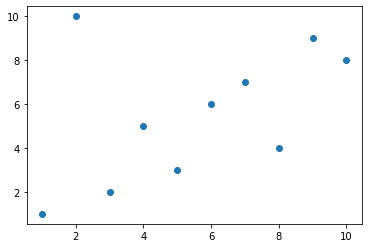

In [21]:
print("method 1\n\n")
loadData()
#df_train.columns
#print(df_train.groupby('attack_cat')['attack_cat'].count())
#balanceClass()
#print(df_train.groupby('label')['label'].count())
#addOtherLabel()
removeDuplicate()
splitData()


X_train, X_test = one_hot_encode(X_train,X_test)
#X_train,X_test = labelEncoding(X_train,X_test)
X_train, X_test = scaling(X_train,X_test,StandardScaler())
#X_train,X_test = runPCA(X_train,X_test,15)

Gmm(X_train)



method 1


Duplicates train: 9
0
Duplicates test: 3
0
X_train shape : (125964, 122)
X_test shape : (22541, 122)
Fitting 1 folds for each of 4 candidates, totalling 4 fits
[CV] n_components=1 ..................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_components=1, score=(train=-106.936, test=-106.936), total=   2.3s
[CV] n_components=2 ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s


[CV]  n_components=2, score=(train=-97.237, test=-97.237), total=   4.2s
[CV] n_components=3 ..................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.4s remaining:    0.0s


[CV]  n_components=3, score=(train=278.822, test=278.822), total=  14.2s
[CV] n_components=4 ..................................................
[CV]  n_components=4, score=(train=243.663, test=243.663), total=  18.5s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   42.0s finished


   mean_fit_time  std_fit_time  ...  mean_train_score  std_train_score
0       2.031035           0.0  ...       -106.936359              0.0
1       3.673278           0.0  ...        -97.237249              0.0
2      13.381794           0.0  ...        278.822450              0.0
3      17.469504           0.0  ...        243.662731              0.0

[4 rows x 13 columns]


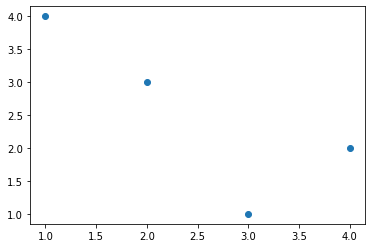

In [40]:
print("method 1\n\n")
loadData()
#df_train.columns
#print(df_train.groupby('attack_cat')['attack_cat'].count())
#balanceClass()
#print(df_train.groupby('label')['label'].count())
#addOtherLabel()
removeDuplicate()
splitData()


X_train, X_test = one_hot_encode(X_train,X_test)
#X_train,X_test = labelEncoding(X_train,X_test)
X_train, X_test = scaling(X_train,X_test,StandardScaler())
#X_train,X_test = runPCA(X_train,X_test,15)

Gmm(X_train)


In [ ]:
print("method 1\n\n")
loadData()
#df_train.columns
#print(df_train.groupby('attack_cat')['attack_cat'].count())
#balanceClass()
#print(df_train.groupby('label')['label'].count())
#addOtherLabel()
removeDuplicate()
splitData()


X_train, X_test = one_hot_encode(X_train,X_test)
#X_train,X_test = labelEncoding(X_train,X_test)
X_train, X_test = scaling(X_train,X_test,StandardScaler())
#X_train,X_test = runPCA(X_train,X_test,15)

searchGmm(X_train)


In [ ]:
print("method 1\n\n")
loadData()
#df_train.columns
#print(df_train.groupby('attack_cat')['attack_cat'].count())
#balanceClass()
#print(df_train.groupby('label')['label'].count())
#addOtherLabel()
removeDuplicate()
splitData()


X_train, X_test = one_hot_encode(X_train,X_test)
#X_train,X_test = labelEncoding(X_train,X_test)
X_train, X_test = scaling(X_train,X_test,StandardScaler())
#X_train,X_test = runPCA(X_train,X_test,15)

searchGmm(X_train)


In [ ]:

print("method 1\n\n")
loadData()
#df_train.columns
#print(df_train.groupby('attack_cat')['attack_cat'].count())
#balanceClass()
#print(df_train.groupby('label')['label'].count())
#addOtherLabel()
removeDuplicate()
splitData()


X_train, X_test = one_hot_encode(X_train,X_test)
#X_train,X_test = labelEncoding(X_train,X_test)
X_train, X_test = scaling(X_train,X_test,StandardScaler())
#X_train,X_test = runPCA(X_train,X_test,15)

searchGmm(X_train)